In [1]:
import yfinance as yf


In [5]:
#user_input
stock_symbol=str(input("Please enter the correct ticker name of the stock:"))

Please enter the correct ticker name of the stock:TCS.NS


In [6]:
print(stock_symbol)

TCS.NS


In [7]:
#last 5 years data with interval of 1 day
data = yf.download(tickers=stock_symbol,period='5y',interval='1d')

[*********************100%***********************]  1 of 1 completed


In [8]:
type(data)

pandas.core.frame.DataFrame

In [9]:
data.head()

,Open,High,Low,Close,Adj Close,Volume
Date,,,,,,
2017-05-23,1266.599976,1282.074951,1257.000000,1260.849976,1146.229248,2748596
2017-05-24,1267.400024,1285.000000,1264.824951,1279.574951,1163.252075,2534548
2017-05-25,1288.500000,1318.775024,1284.000000,1312.300049,1193.002075,4094094
2017-05-26,1312.500000,1313.425049,1282.324951,1289.125000,1171.934082,1362550
2017-05-29,1289.500000,1298.250000,1282.000000,1286.425049,1169.479492,1749290


In [10]:
data.tail()

,Open,High,Low,Close,Adj Close,Volume
Date,,,,,,
2022-05-17,3370.000000,3467.000000,3350.399902,3451.600098,3451.600098,1754076
2022-05-18,3465.000000,3495.000000,3443.050049,3448.800049,3448.800049,1866781
2022-05-19,3397.000000,3405.000000,3230.000000,3261.949951,3261.949951,4642963
2022-05-20,3310.000000,3313.899902,3270.050049,3293.000000,3293.000000,3065125
2022-05-23,3304.800049,3338.899902,3267.000000,3326.000000,3326.000000,1519832


In [273]:
len(data)

1259

In [274]:
opn = data[['Open']]

<AxesSubplot:xlabel='Date'>

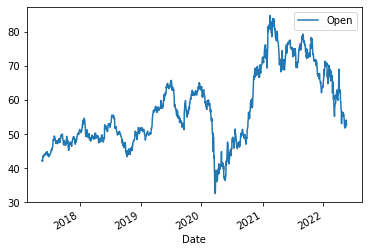

In [275]:
opn.plot()

In [276]:
import matplotlib.pyplot as plt

In [277]:
ds = opn.values

In [278]:
ds

array([[42.25      ],
       [42.41999817],
       [41.99499893],
       ...,
       [54.09000015],
       [53.75      ],
       [52.65999985]])

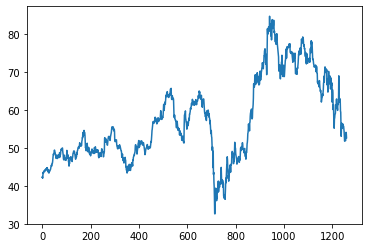

In [279]:
plt.plot(ds)

In [280]:
import numpy as np

In [281]:
#MinMaxScaler preserves the shape of the original distribution. It doesn't meaningfully change the information embedded in the original data. 
from sklearn.preprocessing import MinMaxScaler

In [282]:
#Using MinMaxScaler for normalizing data between 0 & 1
normalizer = MinMaxScaler(feature_range=(0,1))
ds_scaled = normalizer.fit_transform(np.array(ds).reshape(-1,1))

In [283]:
len(ds_scaled), len(ds)

(1259, 1259)

In [284]:
#Defining test and train data sizes
train_size = int(len(ds_scaled)*0.70)
test_size = len(ds_scaled) - train_size

In [285]:
train_size,test_size

(881, 378)

In [286]:
#Splitting data between train and test
ds_train, ds_test = ds_scaled[0:train_size,:], ds_scaled[train_size:len(ds_scaled),:1]

In [287]:
len(ds_train),len(ds_test)

(881, 378)

In [288]:
#creating dataset in time series for LSTM model 
#X[100,120,140,160,180] : Y[200]
def create_ds(dataset,step):
    Xtrain, Ytrain = [], []
    for i in range(len(dataset)-step-1):
        a = dataset[i:(i+step), 0]
        Xtrain.append(a)
        Ytrain.append(dataset[i + step, 0])
    return np.array(Xtrain), np.array(Ytrain)

In [289]:
#Taking 100 days price as one record for training
time_stamp = 100
X_train, y_train = create_ds(ds_train,time_stamp)
X_test, y_test = create_ds(ds_test,time_stamp)

In [290]:
X_train.shape,y_train.shape

((780, 100), (780,))

In [291]:
X_test.shape, y_test.shape

((277, 100), (277,))

In [292]:
#Reshaping data to fit into LSTM model
X_train = X_train.reshape(X_train.shape[0],X_train.shape[1] , 1)
X_test = X_test.reshape(X_test.shape[0],X_test.shape[1] , 1)

In [293]:
from keras.models import Sequential
from keras.layers import Dense, LSTM

In [294]:
#Creating LSTM model using keras
model = Sequential()
model.add(LSTM(units=50,return_sequences=True,input_shape=(X_train.shape[1],1)))
model.add(LSTM(units=50,return_sequences=True))
model.add(LSTM(units=50))
model.add(Dense(units=1,activation='linear'))
model.summary()

Model: "sequential_4"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_12 (LSTM)               (None, 100, 50)           10400     
_________________________________________________________________
lstm_13 (LSTM)               (None, 100, 50)           20200     
_________________________________________________________________
lstm_14 (LSTM)               (None, 50)                20200     
_________________________________________________________________
dense_4 (Dense)              (None, 1)                 51        
Total params: 50,851
Trainable params: 50,851
Non-trainable params: 0
_________________________________________________________________


In [295]:
#Training model with adam optimizer and mean squared error loss function
model.compile(loss='mean_squared_error',optimizer='adam')
model.fit(X_train,y_train,validation_data=(X_test,y_test),epochs=100,batch_size=64)

Epoch 1/100
13/13 [==============================] - 10s 294ms/step - loss: 0.0356 - val_loss: 0.0592
Epoch 2/100
13/13 [==============================] - 2s 168ms/step - loss: 0.0077 - val_loss: 0.0075
Epoch 3/100
13/13 [==============================] - 2s 173ms/step - loss: 0.0046 - val_loss: 0.0114
Epoch 4/100
13/13 [==============================] - 2s 184ms/step - loss: 0.0036 - val_loss: 0.0109
Epoch 5/100
13/13 [==============================] - 2s 168ms/step - loss: 0.0030 - val_loss: 0.0039
Epoch 6/100
13/13 [==============================] - 3s 234ms/step - loss: 0.0028 - val_loss: 0.0043
Epoch 7/100
13/13 [==============================] - 5s 343ms/step - loss: 0.0026 - val_loss: 0.0042
Epoch 8/100
13/13 [==============================] - 3s 193ms/step - loss: 0.0023 - val_loss: 0.0059
Epoch 9/100
13/13 [==============================] - 3s 196ms/step - loss: 0.0021 - val_loss: 0.0062
Epoch 10/100
13/13 [==============================] - 3s 203ms/step - loss: 0.0018 - val_l

13/13 [==============================] - 2s 166ms/step - loss: 6.7487e-04 - val_loss: 9.9917e-04
Epoch 81/100
13/13 [==============================] - 2s 181ms/step - loss: 7.1774e-04 - val_loss: 0.0010
Epoch 82/100
13/13 [==============================] - 2s 178ms/step - loss: 6.3369e-04 - val_loss: 0.0018
Epoch 83/100
13/13 [==============================] - 2s 179ms/step - loss: 5.6713e-04 - val_loss: 0.0014
Epoch 84/100
13/13 [==============================] - 2s 177ms/step - loss: 5.4116e-04 - val_loss: 0.0015
Epoch 85/100
13/13 [==============================] - 2s 170ms/step - loss: 5.5981e-04 - val_loss: 0.0010
Epoch 86/100
13/13 [==============================] - 2s 164ms/step - loss: 5.5638e-04 - val_loss: 0.0012
Epoch 87/100
13/13 [==============================] - 2s 163ms/step - loss: 5.1874e-04 - val_loss: 0.0015
Epoch 88/100
13/13 [==============================] - 2s 165ms/step - loss: 5.1677e-04 - val_loss: 0.0014
Epoch 89/100
13/13 [==============================] - 2

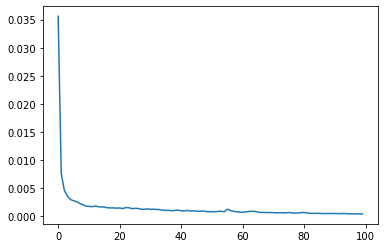

In [296]:
#PLotting loss, it shows that loss has decreased significantly and model trained well
loss = model.history.history['loss']
plt.plot(loss)

In [297]:
#Predicitng on train and test data
train_predict = model.predict(X_train)
test_predict = model.predict(X_test)

In [298]:
#Inverse transform to get actual value
train_predict = normalizer.inverse_transform(train_predict)
test_predict = normalizer.inverse_transform(test_predict)

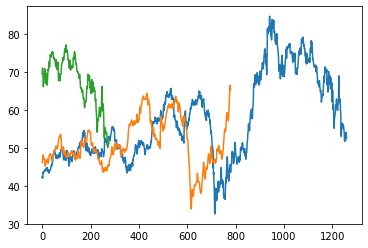

In [299]:
#Comparing using visuals
plt.plot(normalizer.inverse_transform(ds_scaled))
plt.plot(train_predict)
plt.plot(test_predict)

In [300]:
type(train_predict)

numpy.ndarray

In [301]:
test = np.vstack((train_predict,test_predict))

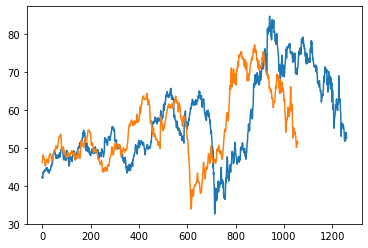

In [302]:
#Combining the predited data to create uniform data visualization
plt.plot(normalizer.inverse_transform(ds_scaled))
plt.plot(test)

In [303]:
len(ds_test)

378

In [304]:
a=len(ds_test)

In [305]:
a

378

In [306]:
b=a-100

In [307]:
b

278

In [308]:
#Getting the last 100 days records
fut_inp = ds_test[b:]

In [309]:
fut_inp = fut_inp.reshape(1,-1)

In [310]:
fut_inp = fut_inp.reshape(1,-1)

In [311]:
tmp_inp = list(fut_inp)

In [312]:
fut_inp.shape

(1, 100)

In [313]:
#Creating list of the last 100 data
tmp_inp = tmp_inp[0].tolist()

In [314]:
#Predicting next 30 days price suing the current data
#It will predict in sliding window manner (algorithm) with stride 1
lst_output=[]
n_steps=100
i=0
while(i<5):
    
    if(len(tmp_inp)>100):
        fut_inp = np.array(tmp_inp[1:])
        fut_inp=fut_inp.reshape(1,-1)
        fut_inp = fut_inp.reshape((1, n_steps, 1))
        yhat = model.predict(fut_inp, verbose=0)
        tmp_inp.extend(yhat[0].tolist())
        tmp_inp = tmp_inp[1:]
        lst_output.extend(yhat.tolist())
        i=i+1
    else:
        fut_inp = fut_inp.reshape((1, n_steps,1))
        yhat = model.predict(fut_inp, verbose=0)
        tmp_inp.extend(yhat[0].tolist())
        lst_output.extend(yhat.tolist())
        i=i+1
    

print(lst_output)

[[0.37326526641845703], [0.3551744818687439], [0.3331657946109772], [0.31138238310813904], [0.2910844385623932]]


In [315]:
len(ds_scaled)

1259

In [316]:
lenth_of_ds_scaled=len(ds_scaled)-100

In [317]:
lenth_of_ds_scaled

1159

In [318]:
#Creating a dummy plane to plot graph one after another
plot_new=np.arange(1,101)
plot_pred=np.arange(101,106)

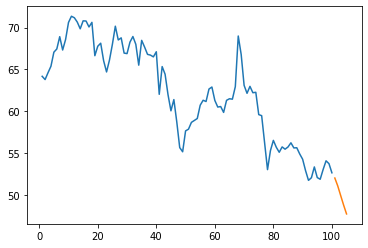

In [319]:
plt.plot(plot_new, normalizer.inverse_transform(ds_scaled[lenth_of_ds_scaled:]))
plt.plot(plot_pred, normalizer.inverse_transform(lst_output))

In [320]:
ds_new = ds_scaled.tolist()
len(ds_new)

1259

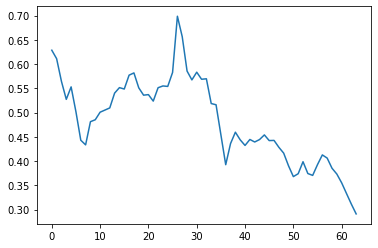

In [321]:
#Entends helps us to fill the missing value with approx value
ds_new.extend(lst_output)
plt.plot(ds_new[1200:])

In [322]:
#Creating final data for plotting
final_graph = normalizer.inverse_transform(ds_new).tolist()

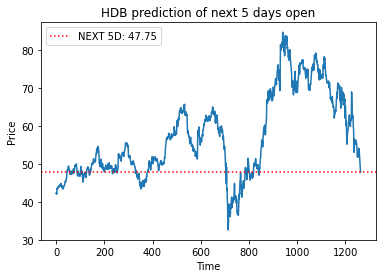

In [323]:
#Plotting final results with predicted value after 5 Days
plt.plot(final_graph,)
plt.ylabel("Price")
plt.xlabel("Time")
plt.title("{0} prediction of next 5 days open".format(stock_symbol))
plt.axhline(y=final_graph[len(final_graph)-1], color = 'red', linestyle = ':', label = 'NEXT 5D: {0}'.format(round(float(*final_graph[len(final_graph)-1]),2)))
plt.legend()